In [1]:
import nipype
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
data = nb.load('/data/func_raw/pp0197/pp0197_B1.nii.gz').get_data()

In [4]:
data.shape

(64, 80, 33, 355)

In [5]:
mean_data = np.mean(data, -1)

(-0.5, 63.5, -0.5, 32.5)

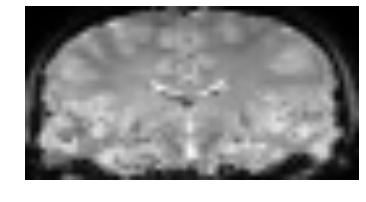

In [6]:
plt.imshow(mean_data[:, 40, :,].T, origin='lower', cmap=plt.cm.gray)
plt.axis('off')

(-0.5, 63.5, -0.5, 79.5)

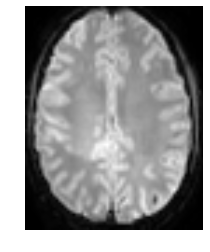

In [7]:
plt.imshow(mean_data[:, :, 20,].T, origin='lower', cmap=plt.cm.gray)
plt.axis('off')

In [8]:
from nipype.workflows.fmri.fsl import create_featreg_preproc
import nipype.pipeline.engine as pe
import nipype.interfaces.io as nio

In [9]:
!ls /data/func_raw/

pp0197	pp0381	pp0483	pp0523	pp0544	pp0549	pp0552	pp0554	pp0558
pp0372	pp0471	pp0498	pp0538	pp0548	pp0551	pp0553	pp0555	pp0559


In [10]:
!ls /data/func_raw/pp0197/

pp0197_B1.nii.gz  pp0197_B2.nii.gz


In [11]:
templates = {'func':'/data/func_raw/pp{subject_id}/pp{subject_id}_B*.nii.gz'}

In [12]:
selector = pe.Node(nio.SelectFiles(templates), name='selector')

In [13]:
preproc_workflow = create_featreg_preproc()

preproc_workflow.base_dir = '/data/workflow_folders'

In [14]:
preproc_workflow.inputs.inputspec.fwhm = 0.0
preproc_workflow.inputs.inputspec.highpass = 128 / 2 / 2

In [18]:
import glob
import os

subject_ids = [os.path.split(fn)[1][2:] for fn in glob.glob('/data/func_raw/*')]
subject_ids

['0498',
 '0544',
 '0538',
 '0553',
 '0552',
 '0197',
 '0549',
 '0551',
 '0559',
 '0558',
 '0471',
 '0483',
 '0554',
 '0548',
 '0523',
 '0372',
 '0381',
 '0555']

In [19]:
preproc_workflow.connect(selector, 'func', preproc_workflow.get_node("inputspec"), 'func')

selector.iterables = [('subject_id', subject_ids)]

In [20]:
ds = pe.Node(nio.DataSink(), name='datasink')
ds.inputs.base_directory = '/data/preprocessed_data/'

In [21]:
preproc_workflow.outputs.outputspec


highpassed_files = None
mask = None
mean = None
motion_parameters = None
motion_plots = None
realigned_files = None
reference = None
smoothed_files = None

In [22]:
preproc_workflow.connect(preproc_workflow.get_node("outputspec"), 'highpassed_files', ds, 'highpassed_files')
preproc_workflow.connect(preproc_workflow.get_node("outputspec"), 'mean', ds, 'mean')

In [23]:
from IPython.display import Image

In [24]:
preproc_workflow.write_graph()

INFO:workflow:Converting dotfile: /data/workflow_folders/featpreproc/graph.dot to png format


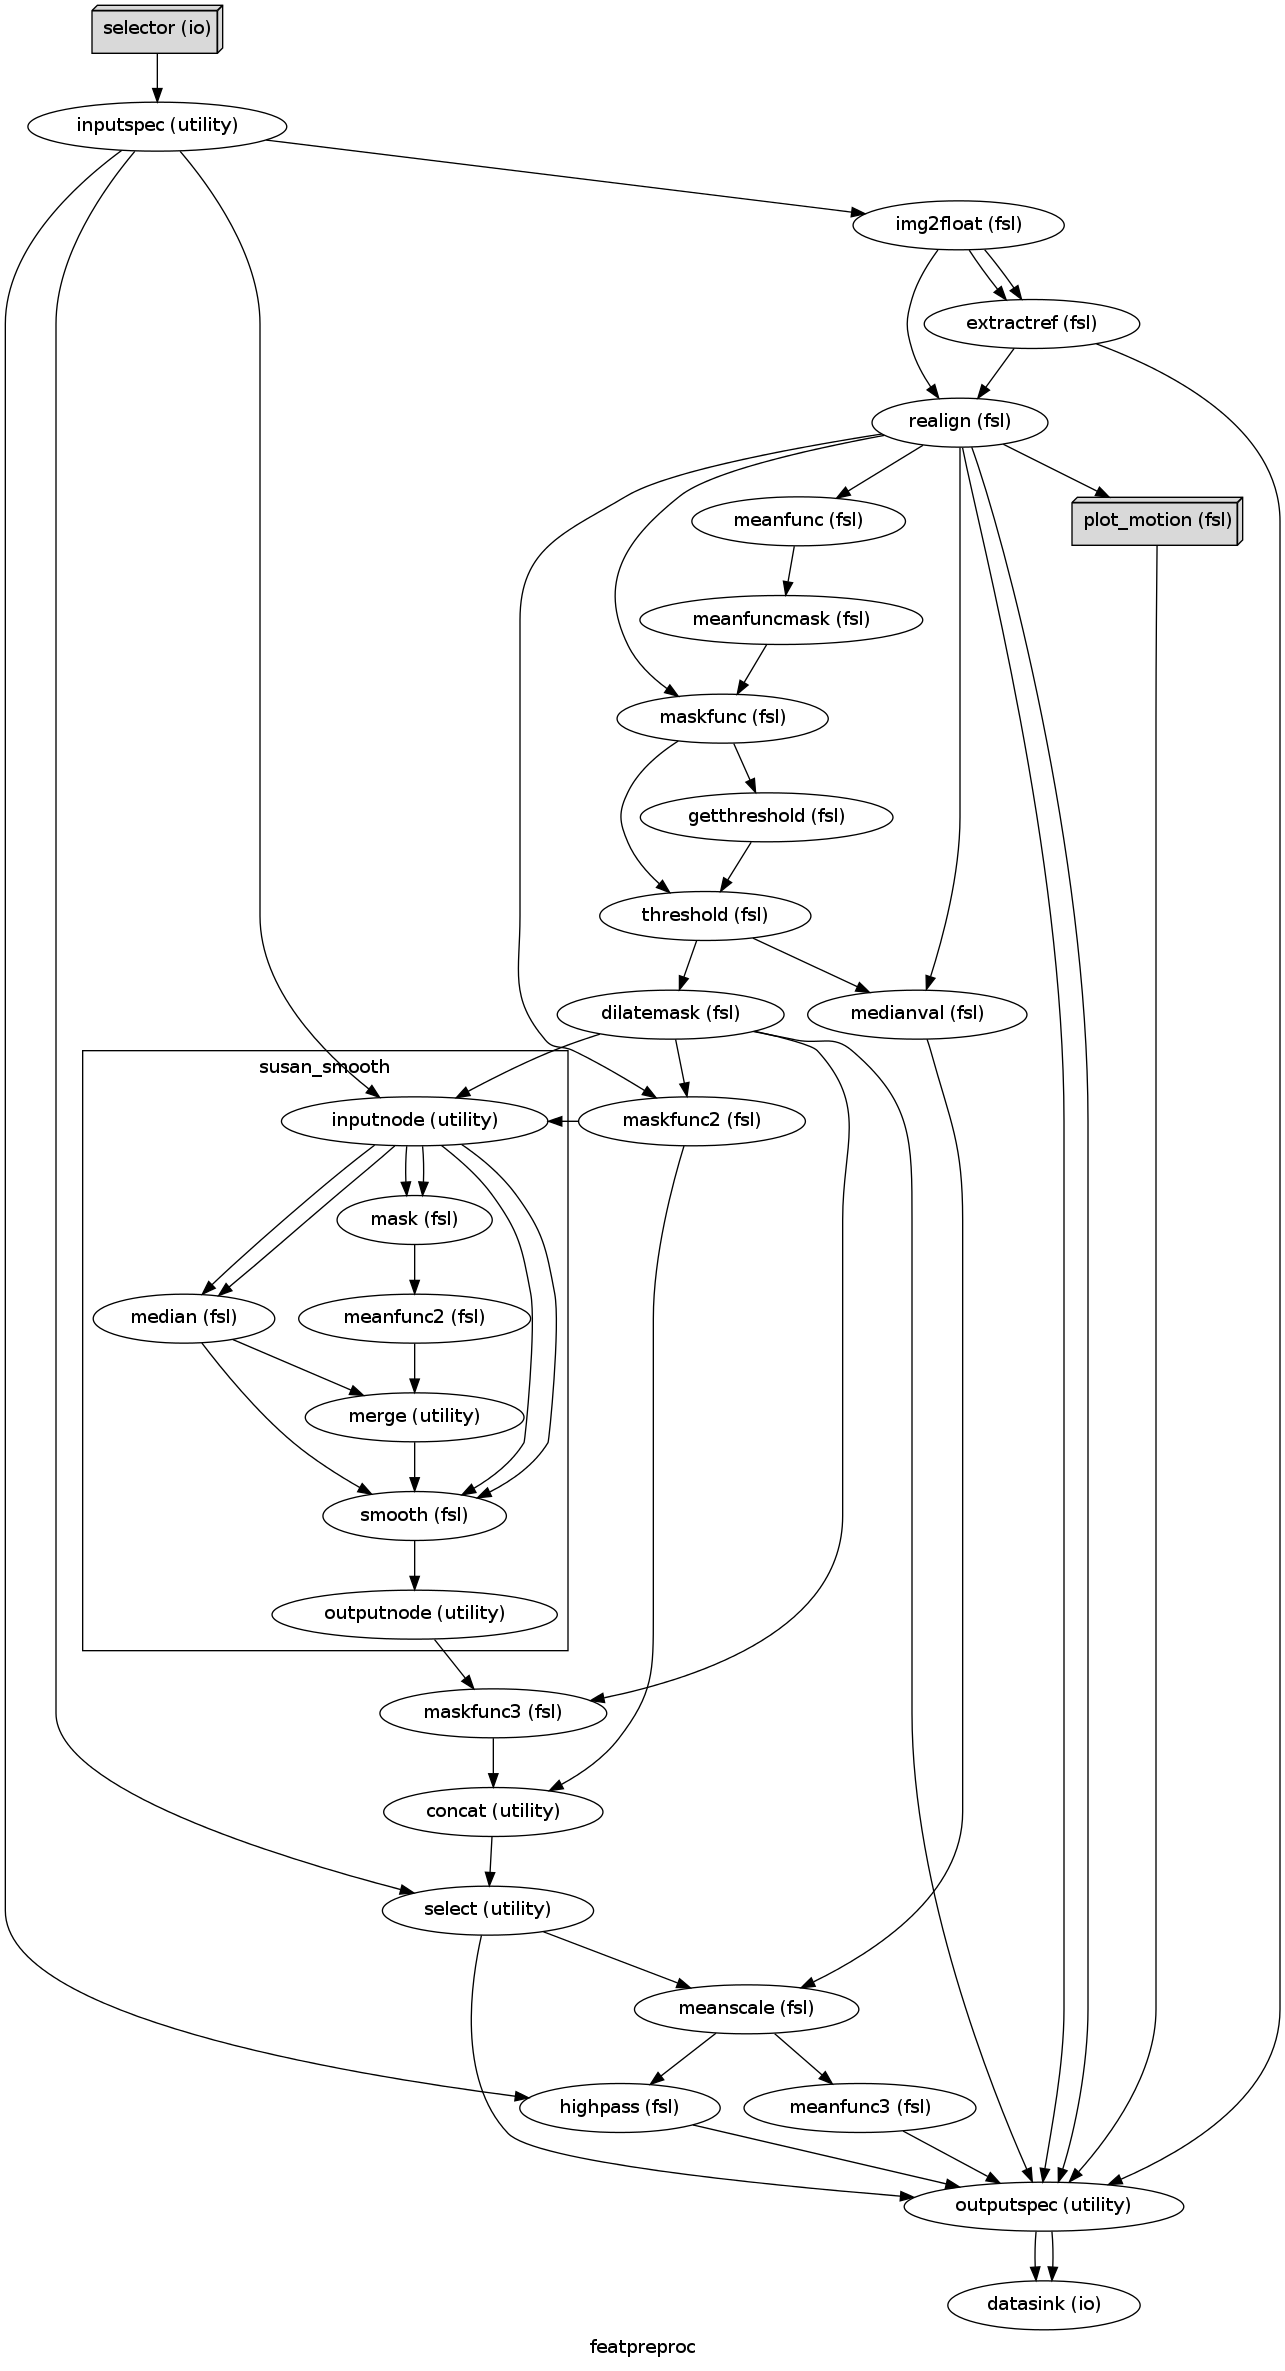

In [25]:
Image('/data/workflow_folders/featpreproc/graph.dot.png')

In [26]:
preproc_workflow.run(plugin='MultiProc', plugin_args={'n_procs' : 30})

INFO:workflow:['check', 'execution', 'logging']
INFO:workflow:Running in parallel.
INFO:workflow:Submitting 18 jobs
INFO:workflow:Executing: selector.bI.b14 ID: 0
INFO:workflow:Executing: selector.bI.b00 ID: 1
INFO:workflow:Executing: selector.bI.b15 ID: 33
INFO:workflow:Executing: selector.bI.b03 ID: 36
INFO:workflow:Executing: selector.bI.b09 ID: 44
INFO:workflow:Executing: selector.bI.b11 ID: 53
INFO:workflow:Executing node selector.bI.b14 in dir: /data/workflow_folders/featpreproc/_subject_id_0523/selector
INFO:workflow:Executing node selector.bI.b00 in dir: /data/workflow_folders/featpreproc/_subject_id_0498/selector
INFO:workflow:Executing: selector.bI.b10 ID: 55
INFO:workflow:Executing node selector.bI.b15 in dir: /data/workflow_folders/featpreproc/_subject_id_0372/selector
INFO:workflow:Executing node selector.bI.b03 in dir: /data/workflow_folders/featpreproc/_subject_id_0553/selector
INFO:workflow:Executing: selector.bI.b16 ID: 67
INFO:workflow:Executing node selector.bI.b09 i

In [32]:
from nipype.workflows.fmri.fsl import create_reg_workflow
import nipype.interfaces.fsl as fsl

In [33]:
registration = create_reg_workflow()
registration.base_dir = '/data/workflow_folders/'

In [34]:
registration.inputs.inputspec.target_image = fsl.Info.standard_image('MNI152_T1_2mm.nii.gz')
registration.inputs.inputspec.target_image_brain = fsl.Info.standard_image('MNI152_T1_2mm_brain.nii.gz')
registration.inputs.inputspec.config_file = 'T1_2_MNI152_2mm'